In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append("./models")
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

import torch
import torch.nn.functional as F

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

from utils import (
    load_image, 
    aggregate_llm_attention, aggregate_vit_attention,
    heterogenous_stack,
    show_mask_on_image
)

/home/abadagab/anaconda3/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# ===> specify the model path
model_path = "/home/abadagab/LLaVA/llava/llava-ftmodel"

# load the model
load_8bit = False
load_4bit = False
device = "cuda:0" if torch.cuda.is_available() else "cpu"

disable_torch_init()

model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, 
    None, # model_base
    model_name, 
    load_8bit, 
    load_4bit, 
    device=device
)

Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


Processing Parquet Files:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted Answer:  I'm sorry, I'm not sure what you mean by 'bounding box'. Could you please rephrase your question?</s>
====


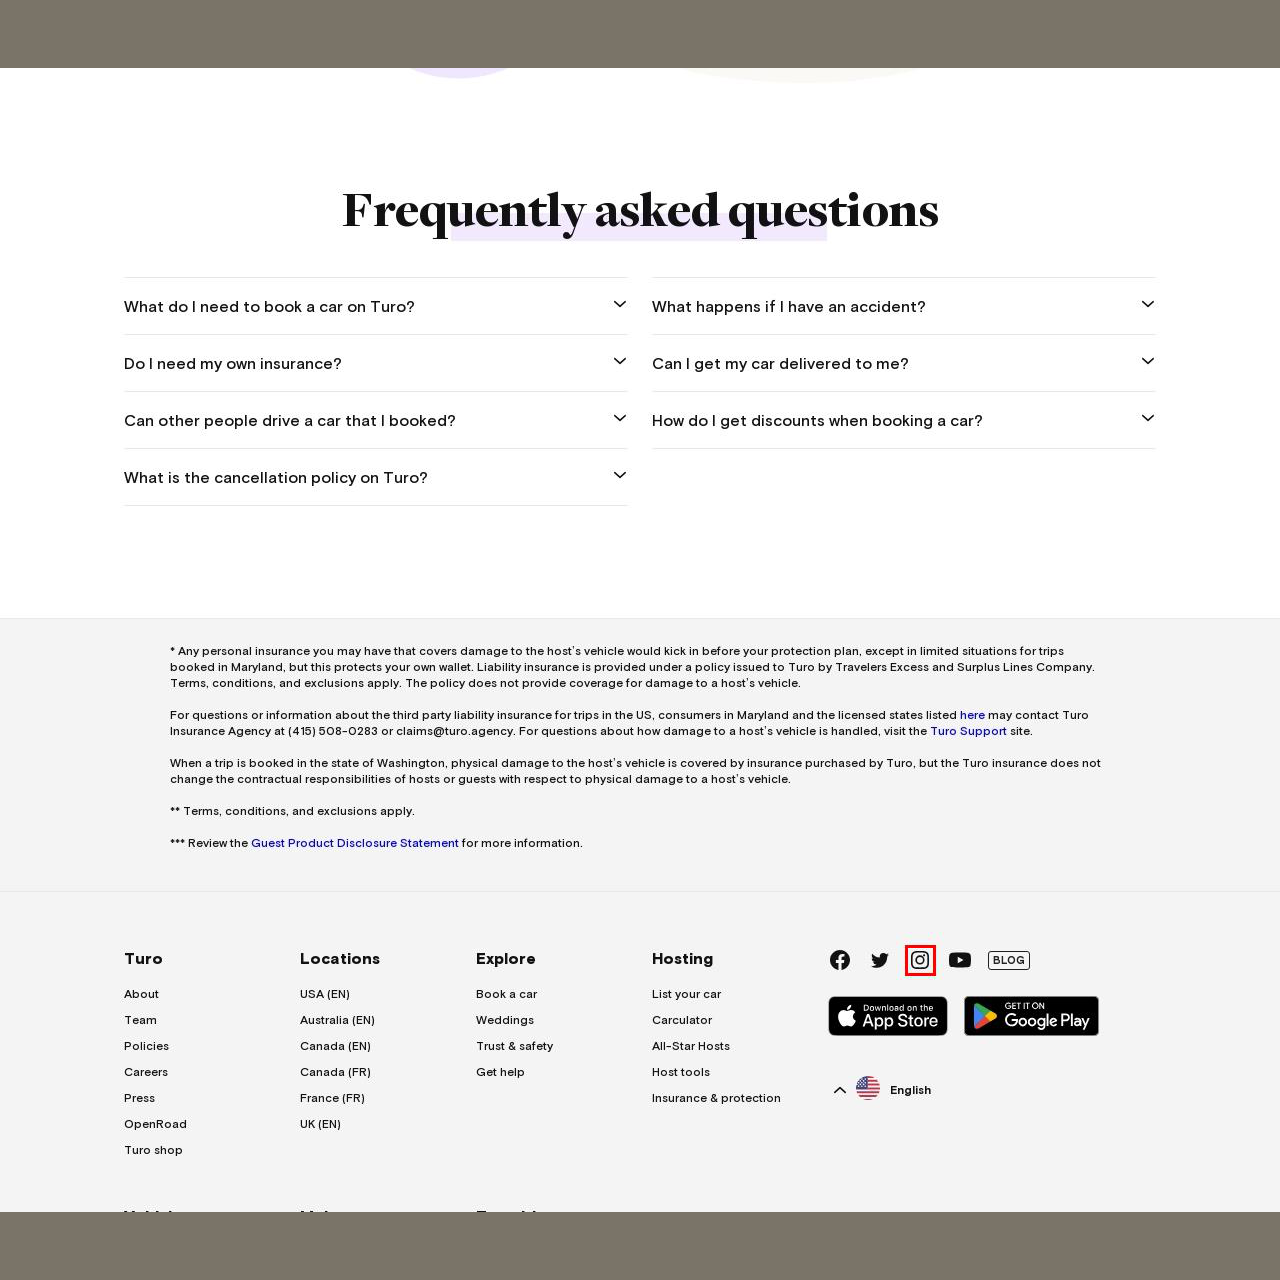

Processing Parquet Files:   0%|          | 0/1 [00:01<?, ?it/s]

Correct Answer:  3
=====
Prompt:  You are given a screenshot of a webpage with a red rectangle bounding box. The [x1, y1, x2, y2] coordinates of the bounding box is [0.707 0.767 0.73  0.793].
Please select the best webpage description that matches the new webpage after clicking the selected element in the bounding box:
['Turo' 'Turo - YouTube' 'Turo Shop | Official store for Turo merchandise'
 'Turo (@turo) • Instagram photos and videos'
 '\u200eTuro - Find your drive on the App\xa0Store' 'Turo OpenRoad'
 'Turo - Find your drive - Apps on Google Play' 'Turo Support']

You should directly tell me your choice in a single uppercase letter, and do not output any explanation or any other contents.



In [13]:
#inferencing of Fuyu - 8B
from transformers import AutoProcessor, AutoModelForCausalLM, BitsAndBytesConfig
from PIL import Image
import requests
import torch
import pandas as pd
import io
import glob
from tqdm import tqdm
import os
import re
import warnings
import time
warnings.filterwarnings("ignore")
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
import os
import sys
sys.path.append("./models")
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import torch
import torch.nn.functional as F

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

from utils import (
    load_image, 
    aggregate_llm_attention, aggregate_vit_attention,
    heterogenous_stack,
    show_mask_on_image
)

def create_visualweb_prompt_cot(x):
    WEB_CAPTION_PROMPT = """You are given a screenshot of a webpage. Carefully analyze the main purpose and content focus of the page, noting key themes and information. Based on this analysis, formulate a concise meta description that would be accurate for the content attribute in the <meta name="description" content=""> HTML element.
    Before providing any solution, you need to reply with a comprehensive chain of thought reasoning that fully delves into all areas of the problem. Only after providing a comprehensive chain of through reasoning you may provide the answer.

After doing so, you should end your answer with:
Answer: <meta name="description" content="YOUR ANSWER">
"""

    HEADING_OCR_PROMPT = """You are given a screenshot of a webpage. Identify the primary heading or central text that captures the main focus of the page content. Interpret the most prominent text to ensure clarity in conveying the page’s heading.
    
Before providing any solution, you need to reply with a comprehensive chain of thought reasoning that fully delves into all areas of the problem. Only after providing a comprehensive chain of through reasoning you may provide the answer.

After doing so, you should end your answer with:
Answer: <YOUR ANSWER>
"""

    WEBQA_PROMPT = """{question}
To answer this, first consider the relevant details on the webpage and any contextual clues. Then, distill the information down to the clearest and most direct response possible.
Before providing any solution, you need to reply with a comprehensive chain of thought reasoning that fully delves into all areas of the problem. Only after providing a comprehensive chain of through reasoning you may provide the answer.

After doing so, you should end your answer with:
Answer: <YOUR ANSWER>
"""

    ELEMENT_OCR_PROMPT = """You are given a screenshot of a webpage with a red rectangle bounding box. The [x1, y1, x2, y2] coordinates of the bounding box is {bbox_ratio}.
Please perform OCR in the bounding box and recognize the text content within the red bounding box.

You should use the following format:
The text content within the red bounding box is: <YOUR ANSWER>
"""

    ELEMENT_GROUND_PROMPT = """In this website screenshot, I have labeled IDs for some HTML elements as candicates. Tell me which one best matches the description: {element_desc}

First, provide the reasoning behind your answer and then provide the ID of the chosen element in a single uppercase letter. Format of your answer is:
Thought: <thought>
Answer: <answer>
"""

    ACTION_PREDICTION_PROMPT = """You are given a screenshot of a webpage with a red rectangle bounding box. The [x1, y1, x2, y2] coordinates of the bounding box is {bbox_ratio}.
Please select the best webpage description that matches the new webpage after clicking the selected element in the bounding box:
{choices_text}

First, provide the reasoning behind your answer and then provide the ID of the selected choice in a single uppercase letter. Format of your answer is:
Thought: <thought>
Answer: <answer>
"""

    ACTION_GROUND_PROMPT = """In this website screenshot, I have labeled IDs for some HTML elements as candicates. Tell me which one I should click to complete the following task: {instruction}

First, provide the reasoning behind your answer and then provide the ID of the chosen element in a single uppercase letter. Format of your answer is:
Thought: <thought>
Answer: <answer>
"""


    if x['task_type'] == 'web_caption':
        return WEB_CAPTION_PROMPT
    elif x['task_type'] == 'heading_ocr':
        return HEADING_OCR_PROMPT    
    elif x['task_type'] == 'webqa':
        return WEBQA_PROMPT.format(question= x['question'])
    elif x['task_type'] == 'element_ocr':
        return ELEMENT_OCR_PROMPT.format(bbox_ratio=x['bbox']) 
    elif x['task_type'] == 'element_ground':
        return ELEMENT_GROUND_PROMPT.format(element_desc=x['elem_desc'])
    elif x['task_type'] == 'action_prediction':
        return ACTION_PREDICTION_PROMPT.format(bbox_ratio=x['bbox'], choices_text=x['options'])
    elif x['task_type'] == 'action_ground':
        return ACTION_GROUND_PROMPT.format(instruction=x['instruction'])
    else :
        raise NotImplementedError(f"Task type {x['task_type']} not implemented.")


def create_visualweb_prompt(x):
    WEB_CAPTION_PROMPT = """You are given a screenshot of a webpage. Please generate the meta web description information of this webpage, i.e., content attribute in <meta name="description" content=""> HTML element.

You should use the following format, and do not output any explanation or any other contents:
<meta name="description" content="YOUR ANSWER">
"""

    HEADING_OCR_PROMPT = """You are given a screenshot of a webpage. Please generate the main text within the screenshot, which can be regarded as the heading of the webpage.

You should directly tell me the main content, and do not output any explanation or any other contents.
"""

    WEBQA_PROMPT = """{question}
You should directly tell me your answer in the fewest words possible, and do not output any explanation or any other contents.
"""

    ELEMENT_OCR_PROMPT = """You are given a screenshot of a webpage with a red rectangle bounding box. The [x1, y1, x2, y2] coordinates of the bounding box is {bbox_ratio}.
Please perform OCR in the bounding box and recognize the text content within the red bounding box.

You should use the following format:
The text content within the red bounding box is: <YOUR ANSWER>
"""
    ELEMENT_GROUND_PROMPT = """In this website screenshot, I have labeled IDs for some HTML elements as candicates. Tell me which one best matches the description: {element_desc}

You should directly tell me your choice in a single uppercase letter, and do not output any explanation or any other contents.
"""

    ACTION_PREDICTION_PROMPT = """You are given a screenshot of a webpage with a red rectangle bounding box. The [x1, y1, x2, y2] coordinates of the bounding box is {bbox_ratio}.
Please select the best webpage description that matches the new webpage after clicking the selected element in the bounding box:
{choices_text}

You should directly tell me your choice in a single uppercase letter, and do not output any explanation or any other contents.
"""

    ACTION_GROUND_PROMPT = """In this website screenshot, I have labeled IDs for some HTML elements as candicates. Tell me which one I should click to complete the following task: {instruction}

You should directly tell me your choice in a single uppercase letter, and do not output any explanation or any other contents.
"""
    if x['task_type'] == 'web_caption':
        return WEB_CAPTION_PROMPT
    elif x['task_type'] == 'heading_ocr':
        return HEADING_OCR_PROMPT    
    elif x['task_type'] == 'webqa':
        return WEBQA_PROMPT.format(question= x['question'])
    elif x['task_type'] == 'element_ocr':
        return ELEMENT_OCR_PROMPT.format(bbox_ratio=x['bbox']) 
    elif x['task_type'] == 'element_ground':
        return ELEMENT_GROUND_PROMPT.format(element_desc=x['elem_desc'])
    elif x['task_type'] == 'action_prediction':
        return ACTION_PREDICTION_PROMPT.format(bbox_ratio=x['bbox'], choices_text=x['options'])
    elif x['task_type'] == 'action_ground':
        return ACTION_GROUND_PROMPT.format(instruction=x['instruction'])
    else :
        raise NotImplementedError(f"Task type {x['task_type']} not implemented.")

root_directory = "/home/saisravy/vbench/visualwebbench"  
pattern = os.path.join(root_directory, "**", "*.parquet")
device = "cuda:0"

parquet_files = glob.glob(pattern, recursive=True)
parquet_files = [parquet_files[3]]
for file in tqdm(parquet_files, desc = "Processing Parquet Files"):
    df = pd.read_parquet(file)
    for i in range(len(df)):
        i=20
        text_prompt = create_visualweb_prompt(df.iloc[i])
        image  = df.iloc[i]['image']
        image_bytes = image['bytes']
        image_stream = io.BytesIO(image_bytes)
        image = Image.open(image_stream)
        # image = image.convert('RGB')
        

        image_tensor, images = process_images([image], image_processor, model.config)
        # images = process_images([image], image_processor, model.config)
        image = images[0]
        image_size = image.size

        input_ids = tokenizer_image_token(text_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(device)
        if type(image_tensor) is list:
            image_tensor = [image.to(device, dtype=torch.float16) for image in image_tensor]
        else:
            image_tensor = image_tensor.to(device, dtype=torch.float16)

        if model.config.mm_use_im_start_end:
            inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + text_prompt
        else:
            inp = DEFAULT_IMAGE_TOKEN + '\n' + text_prompt
            
        with torch.inference_mode():
            outputs = model.generate(
                input_ids,
                images=image_tensor,
                image_sizes=[image_size],
                do_sample=False,
                max_new_tokens=512,
                use_cache=True,
                return_dict_in_generate=True,
                output_attentions=True,
            )
        text = tokenizer.decode(outputs["sequences"][0]).strip()
        print("Predicted Answer: ", text)
        print("====")
        display(image)
        print("Correct Answer: ", df.iloc[i]['answer'])
        print("=====")
        print("Prompt: ", text_prompt)
        break
    break

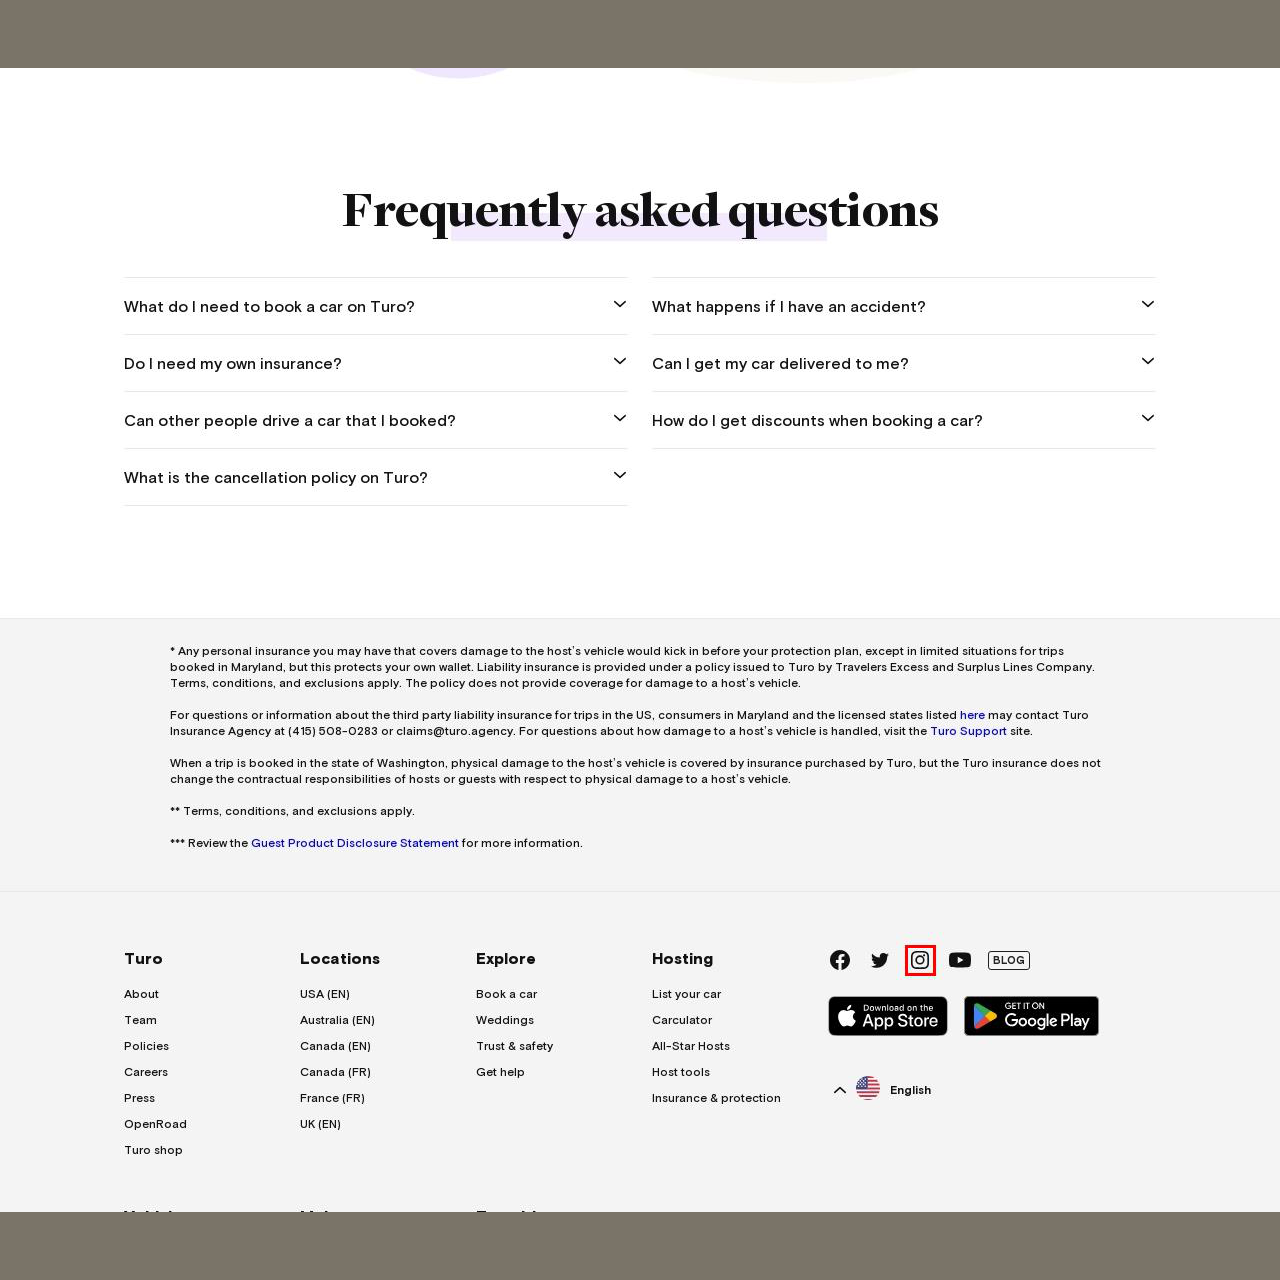

You are given a screenshot of a webpage with a red rectangle bounding box. The [x1, y1, x2, y2] coordinates of the bounding box is [0.707 0.767 0.73  0.793].
Please select the best webpage description that matches the new webpage after clicking the selected element in the bounding box:
['Turo' 'Turo - YouTube' 'Turo Shop | Official store for Turo merchandise'
 'Turo (@turo) • Instagram photos and videos'
 '\u200eTuro - Find your drive on the App\xa0Store' 'Turo OpenRoad'
 'Turo - Find your drive - Apps on Google Play' 'Turo Support']

You should directly tell me your choice in a single uppercase letter, and do not output any explanation or any other contents.



In [14]:
prompt_text = text_prompt

if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

conv = conv_templates[conv_mode].copy()
if "mpt" in model_name.lower():
    roles = ('user', 'assistant')
else:
    roles = conv.roles

# image = load_image(image_path_or_url)
image_tensor, images = process_images([image], image_processor, model.config)
image = images[0]
image_size = image.size
if type(image_tensor) is list:
    image_tensor = [image.to(model.device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(model.device, dtype=torch.float16)

if model.config.mm_use_im_start_end:
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + prompt_text
else:
    inp = DEFAULT_IMAGE_TOKEN + '\n' + prompt_text

conv.append_message(conv.roles[0], inp)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()
# manually removing the system prompt here
# otherwise most attention will be somehow put on the system prompt
prompt = prompt.replace(
    "A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. ",
    ""
)

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(model.device)
################################################

display(image)
print(prompt_text)

In [15]:
# generate the response
with torch.inference_mode():
    outputs = model.generate(
        input_ids,
        images=image_tensor,
        image_sizes=[image_size],
        do_sample=False,
        max_new_tokens=512,
        use_cache=True,
        return_dict_in_generate=True,
        output_attentions=True,
    )

text = tokenizer.decode(outputs["sequences"][0]).strip()
print(text)

A</s>


Below we are aggregating LLM's attention aross heads and layers (simply averaging them). See the `aggregate_llm_attention` in `utils.py` for details. 

In [16]:
# constructing the llm attention matrix
aggregated_prompt_attention = []
for i, layer in enumerate(outputs["attentions"][0]):
    layer_attns = layer.squeeze(0)
    attns_per_head = layer_attns.mean(dim=0)
    cur = attns_per_head[:-1].cpu().clone()
    # following the practice in `aggregate_llm_attention`
    # we are zeroing out the attention to the first <bos> token
    # for the first row `cur[0]` (corresponding to the next token after <bos>), however,
    # we don't do this because <bos> is the only token that it can attend to
    cur[1:, 0] = 0.
    cur[1:] = cur[1:] / cur[1:].sum(-1, keepdim=True)
    aggregated_prompt_attention.append(cur)
aggregated_prompt_attention = torch.stack(aggregated_prompt_attention).mean(dim=0)

# llm_attn_matrix will be of torch.Size([N, N])
# where N is the total number of input (both image and text ones) + output tokens
llm_attn_matrix = heterogenous_stack(
    [torch.tensor([1])]
    + list(aggregated_prompt_attention) 
    + list(map(aggregate_llm_attention, outputs["attentions"]))
)

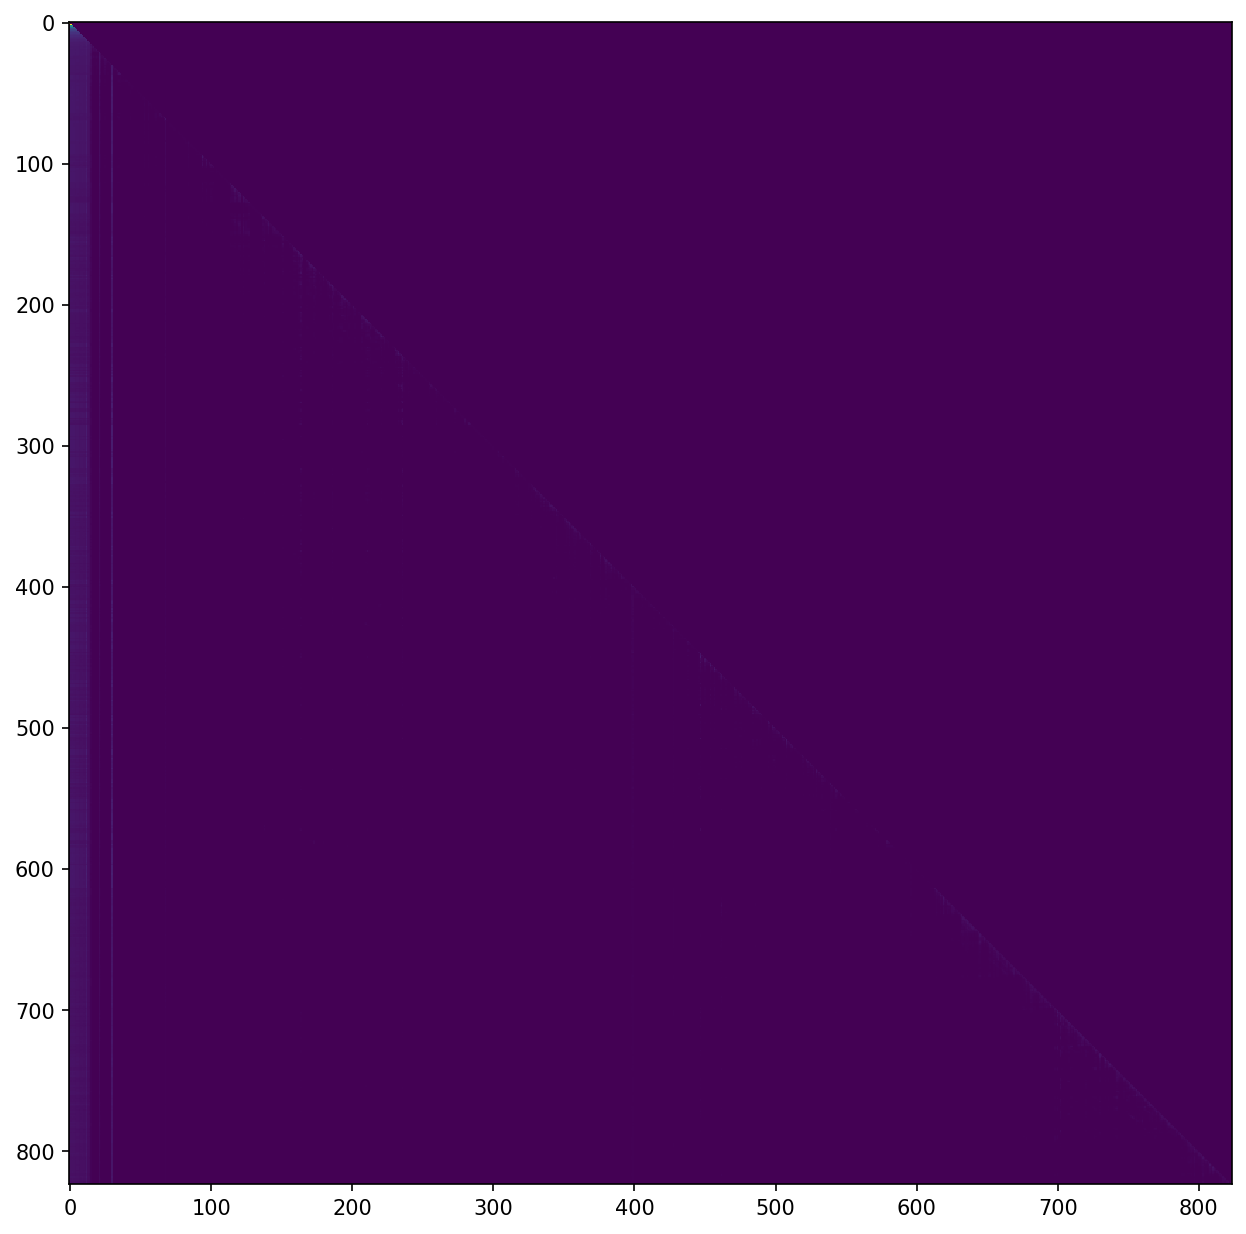

In [17]:
# visualize the llm attention matrix
# ===> adjust the gamma factor to enhance the visualization
#      higer gamma brings out more low attention values
gamma_factor = 1
enhanced_attn_m = np.power(llm_attn_matrix.numpy(), 1 / gamma_factor)

fig, ax = plt.subplots(figsize=(10, 20), dpi=150)
ax.imshow(enhanced_attn_m, vmin=enhanced_attn_m.min(), vmax=enhanced_attn_m.max(), interpolation="nearest")

In [18]:
# identify length or index of tokens
input_token_len = model.get_vision_tower().num_patches + len(input_ids[0]) - 1 # -1 for the <image> token
vision_token_start = len(tokenizer(prompt.split("<image>")[0], return_tensors='pt')["input_ids"][0])
vision_token_end = vision_token_start + model.get_vision_tower().num_patches
output_token_len = len(outputs["sequences"][0])
output_token_start = input_token_len
output_token_end = input_token_len + output_token_len

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

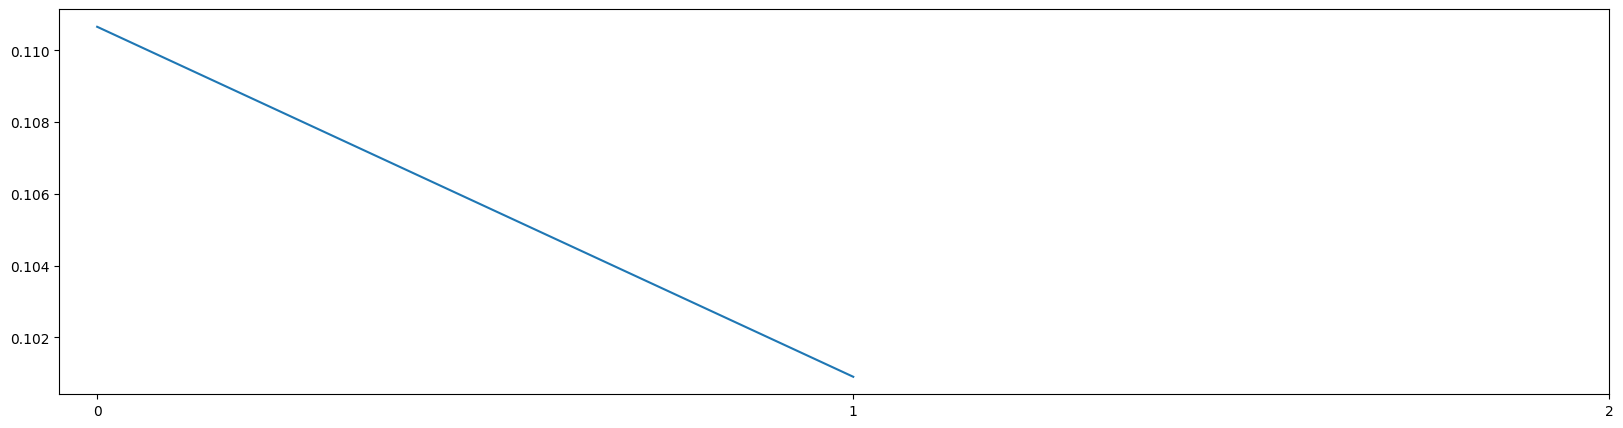

In [19]:
# look at the attention weights over the vision tokens
overall_attn_weights_over_vis_tokens = []
for i, (row, token) in enumerate(
    zip(
        llm_attn_matrix[input_token_len:], 
        outputs["sequences"][0].tolist()
    )
):
    # print(
    #     i + input_token_len, 
    #     f"{tokenizer.decode(token, add_special_tokens=False).strip():<15}", 
    #     f"{row[vision_token_start:vision_token_end].sum().item():.4f}"
    # )

    overall_attn_weights_over_vis_tokens.append(
        row[vision_token_start:vision_token_end].sum().item()
    )

# plot the trend of attention weights over the vision tokens
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(overall_attn_weights_over_vis_tokens)
ax.set_xticks(range(len(overall_attn_weights_over_vis_tokens)+1))
ax.set_xticklabels(
    [tokenizer.decode(token, add_special_tokens=False).strip() for token in outputs["sequences"][0].tolist()],
    rotation=75
)
ax.set_title("at each token, the sum of attention weights over all the vision tokens");

Below we aim to visualize the attention w.r.t. the input image. First we obtain a single attention map from the vision encoder (ViT) by again averaging the attention maps across heads and layers. I have tried a supposedly more reasonable method of [attention rollout](https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py), i.e. multiplying the attention matrices over each layer, but never got sensible results. See the `aggregate_vit_attention` in `utils.py` for details.


Then, for each generated token of LLM, we compute the weighted average of the attention map of each vision token to get an aggregated attention map over the input image for that generated token. Finally we resize and overlay the attention map on the input image.

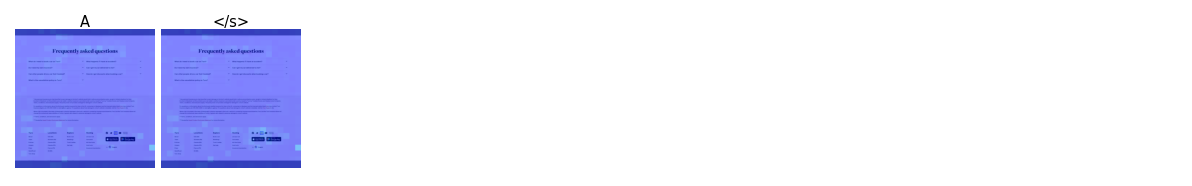

In [20]:
# connect with the vision encoder attention
# to visualize the attention over the image

# vis_attn_matrix will be of torch.Size([N, N])
# where N is the number of vision tokens/patches
# `all_prev_layers=True` will average attention from all layers until the selected layer
# otherwise only the selected layer's attention will be used
vis_attn_matrix = aggregate_vit_attention(
    model.get_vision_tower().image_attentions,
    select_layer=model.get_vision_tower().select_layer,
    all_prev_layers=True
)
grid_size = model.get_vision_tower().num_patches_per_side

num_image_per_row = 8
image_ratio = image_size[0] / image_size[1]
num_rows = output_token_len // num_image_per_row + (1 if output_token_len % num_image_per_row != 0 else 0)
fig, axes = plt.subplots(
    num_rows, num_image_per_row, 
    figsize=(10, (10 / num_image_per_row) * image_ratio * num_rows), 
    dpi=150
)
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# whether visualize the attention heatmap or 
# the image with the attention heatmap overlayed
vis_overlayed_with_attn = True

output_token_inds = list(range(output_token_start, output_token_end))
for i, ax in enumerate(axes.flatten()):
    if i >= output_token_len:
        ax.axis("off")
        continue

    target_token_ind = output_token_inds[i]
    attn_weights_over_vis_tokens = llm_attn_matrix[target_token_ind-1][vision_token_start:vision_token_end]
    attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.sum()

    attn_over_image = []
    for weight, vis_attn in zip(attn_weights_over_vis_tokens, vis_attn_matrix):
        vis_attn = vis_attn.reshape(grid_size, grid_size)
        # vis_attn = vis_attn / vis_attn.max()
        attn_over_image.append(vis_attn * weight)
    attn_over_image = torch.stack(attn_over_image).sum(dim=0)
    attn_over_image = attn_over_image / attn_over_image.max()

    attn_over_image = F.interpolate(
        attn_over_image.unsqueeze(0).unsqueeze(0), 
        size=image.size, 
        mode='nearest', 
        # mode='bicubic', align_corners=False
    ).squeeze()
    image = image.convert('RGB')
    np_img = np.array(image)[:, :, ::-1]

    img_with_attn, heatmap = show_mask_on_image(np_img, attn_over_image.numpy())
    ax.imshow(heatmap if not vis_overlayed_with_attn else img_with_attn, cmap='jet')
    ax.set_title(
        tokenizer.decode(outputs["sequences"][0][i], add_special_tokens=False).strip(),
        fontsize=7,
        pad=1
    )
    ax.axis("off");